In [6]:
%matplotlib inline

In [7]:
from IPython.core.display import HTML
css_file = './inet.css'
HTML(open(css_file, "r").read())

In [8]:
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
plt.xkcd()

import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.formula.api as smf

from IPython.html import widgets
from IPython.display import display

import pypwt

:0: FutureWarning: IPython widgets are experimental and may change in the future.


<h1 class="title-slide"> (Linear) Regression </h1>

<h2 class="title-slide"> David R. Pugh</h2>
    
<img class="title-slide" src='./assets/INET_Brand_Final-01.jpg' alt="INET logo">


<h3>Q: What is regression?</h3>

A: Drawing a "line" through a scatter of data points in a principled way...

<h3>Q: What is <em>linear</em> regression?</h3>

A: Drawing a <em>straight</em> "line" through a scatter of data points in a principled way...

<h2>Linear regression in practice</h2>

<h2 class="section-header"> Step 1: Grab some data...</h2>

In [9]:
# grab the entire Penn World Tables data from the web...
pwt = pypwt.load_pwt_data()

In [11]:
#...this gives us a panel (i.e., two dimensional) data set 
pwt

<class 'pandas.core.panel.Panel'>
Dimensions: 38 (items) x 167 (major_axis) x 62 (minor_axis)
Items axis: country to delta_k
Major_axis axis: AGO to ZWE
Minor_axis axis: 1950-01-01 00:00:00 to 2011-01-01 00:00:00

In [23]:
def labor_supply(data, year="1950-01-01"):
    """
    Labor supply in a given year is the product of number of employed
    persons, 'emp', and the average number of hours worked, 'avh'.
    
    Parameters
    ----------
    data : pandas.Panel
        The Penn World Tables (PWT) data set.
    year : str (default="1950-01-01")
        Some year between 1950 and 2011. Format should be "YYYY-01-01".
    
    Returns
    -------
    L : pandas.Series
        Effective labor supply in units of employed person-years.
    
    """
    L = data.minor_xs(year)["emp"] * data.minor_xs(year)["avh"]
    return L


def real_gdp_per_unit_labor(data, year="1950-01-01"):
    """
    Real gross domestic product (GDP) per unit labor is the ratio of
    some measure of real output and some measure of labor supply. 
    
    Parameters
    ----------
    data : pandas.Panel
        The Penn World Tables (PWT) data set.
    year : str (default="1950-01-01")
        Some year between 1950 and 2011. Format should be "YYYY-01-01".
    
    Returns
    -------
    rgdppul : pandas.Series
        Real gdp per unit labor supply.
    
    """
    rgdppul = data.minor_xs(year)["rgdpo"] / labor_supply(data, year)
    return rgdppul


def growth_rate_real_gdp_per_unit_labor(data, start="1950-01-01", end="2011-01-01"):
    """
    Plot the growth rate of real GDP per unit labor over some time period
    against the level of real GDP per unit labor at the start of the time
    period.
    
    Parameters
    ----------
    data : pandas.Panel
        The Penn World Tables (PWT) data set.
    start : str (default="1950-01-01")
        Some year between 1950 and 2011. Format should be "YYYY-01-01".
    end : str (default="2011-01-01")
        Some year between 1950 and 2011. Format should be "YYYY-01-01".
    
    """
    gr = (np.log(real_gdp_per_unit_labor(data, end)) -
          np.log(real_gdp_per_unit_labor(data, start)))
    return gr


def some_interesting_plot(data, start="1950-01-01", end="2011-01-01"):
    """
    Plot the growth rate of real GDP per unit labor over some time period
    against the level of real GDP per unit labor at the start of the time
    period.
    
    Parameters
    ----------
    data : pandas.Panel
        The Penn World Tables (PWT) data set.
    start : str (default="1950-01-01")
        Some year between 1950 and 2011. Format should be "YYYY-01-01".
    end : str (default="2011-01-01")
        Some year between 1950 and 2011. Format should be "YYYY-01-01".
    
    """
    # create the scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(12,9))
    xs = np.log(real_gdp_per_unit_labor(data, start))
    ys = growth_rate_real_gdp_per_unit_labor(data, start, end)
    ax.scatter(xs, ys, color='k')
    
    # axis labels, title, etc
    ax.set_xlabel('Log income (per unit labor) in 1960', fontsize=25)
    ax.set_xlim(0.95 * xs.min(), 1.05 * xs.max())
    ax.set_ylabel('Income (per unit labor) growth\n({}-{})'.format(start[:4], end[:4]),
                  fontsize=25)
    ax.set_ylim(1.05 * ys.min(), 1.05 * ys.max())
    ax.set_title('Do poor countries grow faster than rich countries?',
                 fontsize=25, family="serif")

Let's focus on a relation between...

1. (log) level of real income
2. subsequent growth rate of income 

...note that income is "per unit labor supply"

<h2 class="section-header">Step 2: plot your data...</h2>

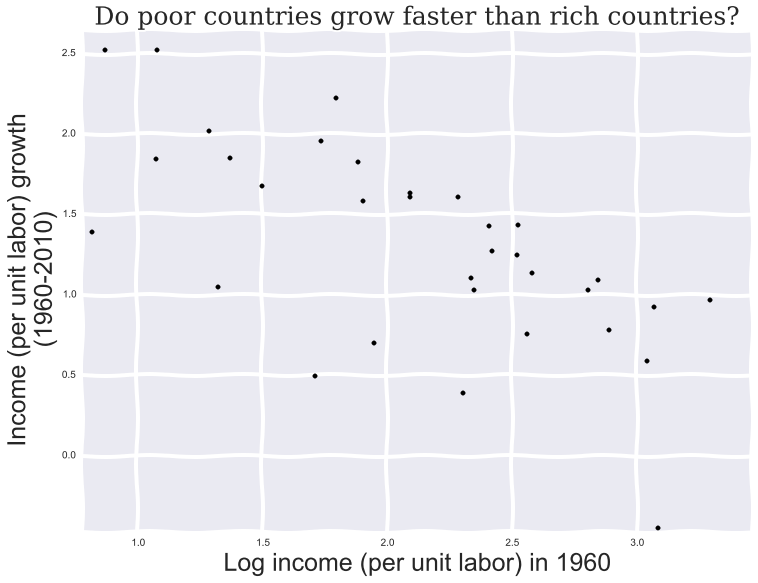

In [24]:
some_interesting_plot(data=pwt, start="1960-01-01", end="2010-01-01")

<h2 class="section-header">Step 3: draw a (straight!) line through your data...</h2>

In [26]:
def another_interesting_plot(data, start, end, intercept=2.5, slope=-0.5):
    """
    Plot the growth rate of real GDP per unit labor over some time period
    against the level of real GDP per unit labor at the start of the time
    period. Then add a regression line associated with given values for the
    intercept and slope.
    
    Parameters
    ----------
    data : pandas.Panel
        The Penn World Tables (PWT) data set.
    start : str (default="1950-01-01")
        Some year between 1950 and 2011. Format should be "YYYY-01-01".
    end : str (default="2011-01-01")
        Some year between 1950 and 2011. Format should be "YYYY-01-01".
    intercept: float (defalut=2.5)
        Intercept for the regression line.
    slope : float (default=-0.5)
        Slope for the regression line.
    
    """
    # create the scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(12,9))
    xs = np.log(real_gdp_per_unit_labor(data, start))
    ys = growth_rate_real_gdp_per_unit_labor(data, start, end)
    ax.scatter(xs, ys, color='k')

    # compute the regression line given params
    grid = np.linspace(0.95 * xs.min(), 1.05 * xs.max(), 1000)
    predicted = lambda x: intercept + slope * x
    yhat, = ax.plot(grid, predicted(grid) , color='b',
                    label=r"$\hat{y}_i=%.2f + %.2fx_i$" %(intercept, slope))
    
    # axis labels, title, etc
    ax.set_xlabel('Log income (per unit labor) in 1960', fontsize=25)
    ax.set_xlim(0.95 * xs.min(), 1.05 * xs.max())
    ax.set_ylabel('Income (per unit labor) growth\n({}-{})'.format(start[:4], end[:4]),
                  fontsize=25)
    ax.set_ylim(1.05 * ys.min(), 1.05 * ys.max())
    ax.legend(bbox_to_anchor=(1.0, 0.95), prop={'size': 25})


Since we are drawing straight lines...

$$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$$

where

\begin{align}
    y_i=& \text{income growth from 1960-2010} \\
    x_i=& \ln (\text{income in 1960})
\end{align}

and $i=\text{AGO},\dots,\text{ZWE}$.

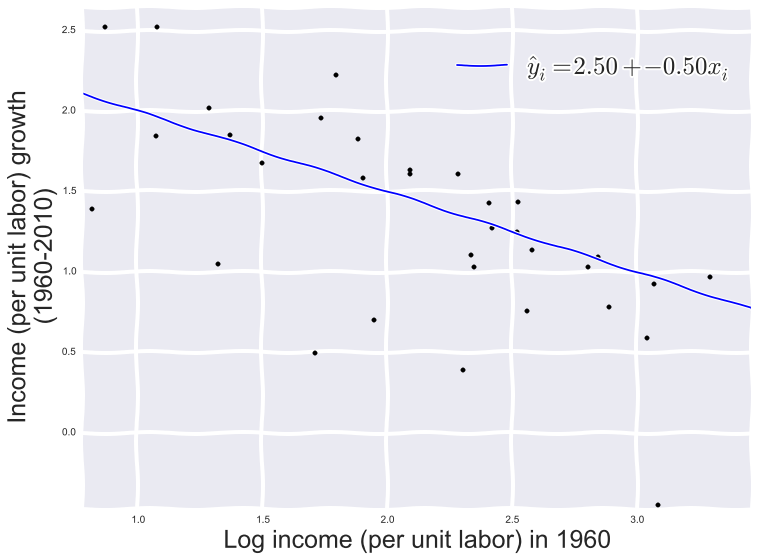

In [27]:
another_interesting_plot(pwt, start="1960-01-01", end="2010-01-01")

<h2 class="section-header">Step 4: choose some measure of deviation between model and data...</h2>

Given our choice of model...

$$ y_i = \beta_0 + \beta_1 x_i + \epsilon_i,\ i=1,\dots,N $$

...focus on the sum of squared errors (SSE):

$$ SSE \equiv \sum_{i=1}^N  \epsilon_i^2 = \sum_{i=1}^N \big(y_i - (\beta_0 + \beta_1x_i)\big)^2 $$

<h2 class="section-header">Step 5: choose params to minimize deviation between model and data...</h2>

In [30]:
def another_static_plot(data, start, end, intercept=2.5, slope=-0.5):
    """
    Plot the growth rate of real GDP per unit labor over some time period
    against the level of real GDP per unit labor at the start of the time
    period. Then add a regression line associated with given values for the
    intercept and slope.
    
    Parameters
    ----------
    data : pandas.Panel
        The Penn World Tables (PWT) data set.
    start : str (default="1950-01-01")
        Some year between 1950 and 2011. Format should be "YYYY-01-01".
    end : str (default="2011-01-01")
        Some year between 1950 and 2011. Format should be "YYYY-01-01".
    intercept: float (default=2.5)
        Intercept for the regression line.
    slope : float (default=-0.5)
        Slope for the regression line.
    
    """
    # create the scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(12,9))
    xs = np.log(real_gdp_per_unit_labor(data, start))
    ys = growth_rate_real_gdp_per_unit_labor(data, start, end)
    ax.scatter(xs, ys, color='k')

    # compute and plot the regression line given current params
    predicted = lambda x: intercept + slope * x
    grid = np.linspace(0.95 * xs.min(), 1.05 * xs.max(), 1000)
    yhat, = ax.plot(grid, predicted(grid) , color='b')
    ssr = np.sum((predicted(xs) - ys)**2)
    
    # add the residuals to the plot
    lines = zip(zip(xs, ys), zip(xs, predicted(xs)))
    lc = mc.LineCollection(lines, colors='r', linewidths=2)
    ax.add_collection(lc)
    
    # axis labels, title, etc
    ax.set_xlabel('Log income (per unit labor) in 1960', fontsize=25)
    ax.set_xlim(0.95 * xs.min(), 1.05 * xs.max())
    ax.set_ylabel('Income (per unit labor) growth\n({}-{})'.format(start[:4], end[:4]),
                  fontsize=25)
    fig.suptitle(r'Sum of squared errors (SSE) $\equiv \sum_{i=1}^N (y_i - (\beta_0 + \beta_1x_i))^2$',
                 x=0.5, y=1.025, fontsize=25, family="serif")
    fig.legend([yhat, lc], [r"$\hat{y}_i=\hat{\beta}_0 + \hat{\beta}_1x_i$", r"$SSE={0:.4f}$".format(ssr)],
               bbox_to_anchor=(0.8, 0.85), prop={'size': 25})

    
# create the interactive widget
intercept_widget = widgets.FloatSlider(value=2.5e0, min=0.0, max=5.0, step=5e-2, description=r"$\hat{\beta}_0$")
slope_widget = widgets.FloatSlider(value=-0.5, min=-1.0, max=1.0, step=5e-2, description=r"$\hat{\beta}_1$")
some_interactive_plot = widgets.interactive(another_static_plot,
                                            data=widgets.fixed(pwt),
                                            start=widgets.fixed("1960-01-01"),
                                            end=widgets.fixed("2010-01-01"),
                                            intercept=intercept_widget,
                                            slope=slope_widget,
                                           )

<h3>Informal parameter estimation...</h3>

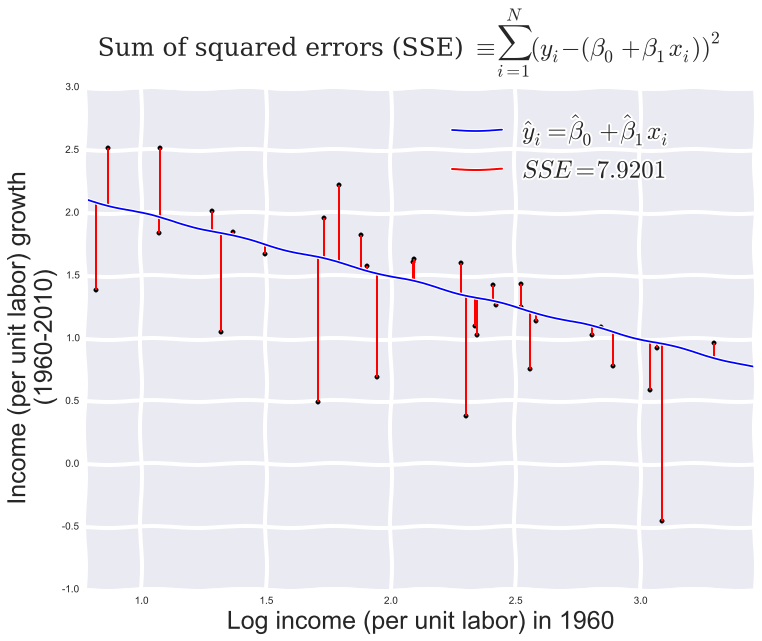

In [31]:
display(some_interactive_plot)

<h3>Formal parameter estimation...</h3>

Our estimates $\hat{\beta}_0$ and $\hat{\beta}_1$ solve the following optimization problem...

$$ \min_{\beta_0, \beta_1} \sum_{i=1}^N (y_i - (\beta_0 + \beta_1x_i))^2 $$

Taking of derivatives yields a system of first-order conditions...

\begin{align}
    0 =& -2\sum_{i=1}^N (y_i - (\beta_0 + \beta_1x_i)) \\
    0 =& -2\sum_{i=1}^N (y_i - (\beta_0 + \beta_1x_i))x_i
\end{align}

...which after some algebra yields...

\begin{align}
    \hat{\beta}_0 =& \bar{y} - \hat{\beta}_1 \bar{x} \\
    \hat{\beta}_1 =& \frac{\frac{1}{N}\sum_{i=1}^N(x_i - \bar{x})(y_i - \bar{y})}{\frac{1}{N}\sum_{i=1}^N(x_i - \bar{x})^2}
\end{align}

Intuition for $\hat{\beta}_1$...

\begin{align}
    \hat{\beta}_1 =& \frac{Cov(x, y)}{Var(x)} \\
    \equiv& \frac{\text{How much do $x$ and $y$ vary together?}}{\text{How much does $x$ vary in general?}}
\end{align}

In [13]:
# compute the optimal parameter estimates "by hand"
estimated_slope = xs.cov(ys) / xs.var()
estimated_intercept = ys.mean() - estimated_slope * xs.mean()

In [14]:
print "Estimated intercept: {}".format(estimated_intercept)
print "Estimated slope: {}".format(estimated_slope)

Estimated intercept: 2.60212926608
Estimated slope: -0.610771408878


In [45]:
# define the variables
xs = np.log(real_gdp_per_unit_labor(pwt, '1960-01-01'))
ys = growth_rate_real_gdp_per_unit_labor(pwt, '1960-01-01', '2010-01-01')

# compute and plot the regression line given current params
data = pd.DataFrame.from_dict({'x': xs, 'y': ys})
lm = smf.ols(formula="y ~ x", data=data).fit()

In [55]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     24.19
Date:                Thu, 21 May 2015   Prob (F-statistic):           2.71e-05
Time:                        10:50:38   Log-Likelihood:                -21.613
No. Observations:                  33   AIC:                             47.23
Df Residuals:                      31   BIC:                             50.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.6021      0.276      9.442      0.000         2.040     3.164
x             -0.6108      0.124     -4.919      0.000        -0.864    -0.358
==============================================================================
Omnibus:                        6.668   Durbin-Watson:                   1.627
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                5.773
Skew:                          -1.021   Prob(JB):                       0.0558
Kurtosis:                       3.178   Cond. No.                         8.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
def plot_fitted_model(data, start="1950-01-01", end="2011-01-01"):
    """
    Plot the growth rate of real GDP per unit labor over some time period
    against the level of real GDP per unit labor at the start of the time
    period. Then add a regression line associated with given values for the
    intercept and slope.
    
    Parameters
    ----------
    data : pandas.Panel
        The Penn World Tables (PWT) data set.
    start : str (default="1950-01-01")
        Some year between 1950 and 2011. Format should be "YYYY-01-01".
    end : str (default="2011-01-01")
        Some year between 1950 and 2011. Format should be "YYYY-01-01".
        
    """
    # create the scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(12,9))
    xs = np.log(real_gdp_per_unit_labor(data, start))
    ys = (np.log(real_gdp_per_unit_labor(data, end)) -
          np.log(real_gdp_per_unit_labor(data, start)))
    ax.scatter(xs, ys, color='k')

    # compute and plot the regression line given current params
    data = pd.DataFrame.from_dict({'x': xs, 'y': ys})
    lm = smf.ols(formula="y ~ x", data=data).fit()
    predicted = lambda x: lm.params[0] + lm.params[1] * x

    grid = np.linspace(0.95 * xs.min(), 1.05 * xs.max(), 1000)
    yhat, = ax.plot(grid, predicted(grid) , color='b')
    ssr = np.sum((predicted(xs) - ys)**2)
    
    # add the residuals to the plot
    lines = zip(zip(xs, ys), zip(xs, predicted(xs)))
    lc = mc.LineCollection(lines, colors='r', linewidths=2)
    ax.add_collection(lc)
    
    # axis labels, title, etc
    ax.set_xlabel('Log income (per unit labor) in 1960', fontsize=25)
    ax.set_xlim(0.95 * xs.min(), 1.05 * xs.max())
    ax.set_ylabel('Income (per unit labor) growth\n({}-{})'.format(start[:4], end[:4]),
                  fontsize=25)
    ax.set_ylim(1.05 * ys.min(), 1.05 * ys.max())
    fig.legend([yhat, lc], [r"$\hat{y}_i=%.4f + %.4f x_i$" % (lm.params[0], lm.params[1]),
                            r"$SSR={0:.4f}$".format(ssr)],
               bbox_to_anchor=(0.85, 0.85), prop={'size': 25})


<h3>Plotting the final result...</h3>

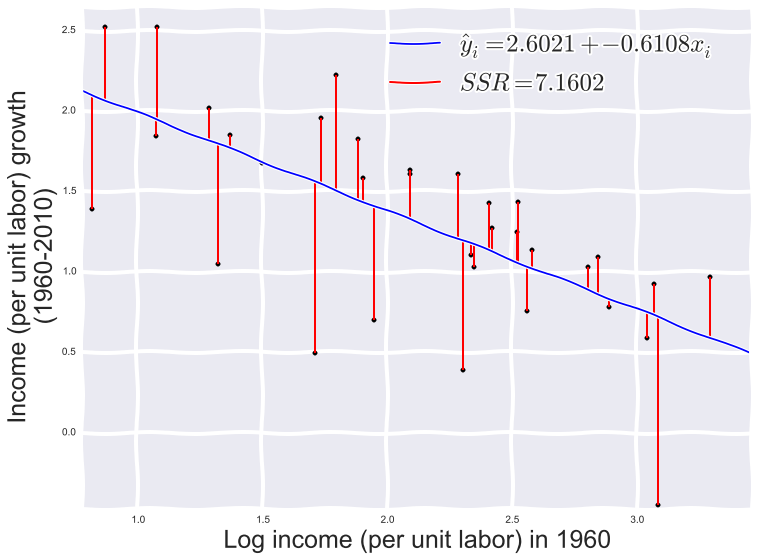

In [54]:
plot_fitted_model(pwt, '1960-01-01', '2010-01-01')

<h2>Have we found any evidence for convergence?</h2>

Yes...

* slope coefficient has the correct sign

...but...

What about...

* Omitted variable bias!
* Sample selection issues!
* Measurement error?
* etc.